In [183]:
%matplotlib inline
from IPython.display import Image
import numpy as np
import tensorflow as tf
import scipy as sp
import tensorflow.contrib.distributions as tfd
import matplotlib.pyplot as plt

# Why we Need Bayesian Inference

## Traditional Machine Learning

Given model hypothesis $H$ parameterized by $\theta$, and data $D$,

\begin{equation}
  p(\theta \mid D, H) = \frac{ p(D \mid \theta, H) p(\theta, H) }{ p(D, H) }
\end{equation}

Bayesian inference $\to$ traditional machine learning
  * likelihood $\to$ mean square error, cross-entropy, etc.
  * prior $\to$ regularization
  * evidence $\to$ ?

So, what the traditional machine learning does is to find the MAP, as
\begin{equation}
  \theta_{\star} = \textrm{argmax}_{\theta} \left\{ p(\theta \mid D, H) \right\}.
\end{equation}
Or equivalently,
\begin{equation}
  \theta_{\star} = \textrm{argmin}_{\theta} \left\{ -\ln p(\theta \mid D, H) \right\}.
\end{equation}

## Encodes More Information

* Even for the simplest dataset with the shallowest neural network, the posterior is not that peaky as you imagine!

Herein we consider a feed-forward neural network with one hidden layer of 15 perceptrons, and the MNIST dataset. Naturally, the output distribution is a `Categorical` (thus the loss is cross-entropy). We visualize the log-PDF of the posterior around the MAP: [click](https://10.201.100.168:8000/notebooks/pxjiang/Visualize%20the%20Posterior%20on%20MNIST-Copy1.ipynb).

* We find that some plots, like axis-11410, are flat around MAP, hinting for a uncertainty (non-confidence).

## Benefits

### Overcome overconfidence

> Modern neural networks tend to be overconfident on unseen, noisy or incorrectly labelled data and do not produce meaningful uncertainty measures. Bayesian deep learning aims to address this shortcoming.

(And more, c.f. the next section.)

\begin{align}
  \hat{y} & = \int d\theta p(\theta \mid D, H) f(x; \theta) \\
          & = \mathbb{E}_{\theta \sim p(\theta \mid D, H)} \left[ f(x; \theta) \right].
\end{align}

### Model Selection: Bayesian Occam’s razor

Given two model hypothesis $H_1$ and $H_2$, and data $D$,

\begin{equation}
  \frac{ p(H_1 \mid D) }{ p(H_2 \mid D) }
  = \frac{ p(H_1, D) p(D) }{ p(H_2, D) p(D) }
  = \frac{ p(H_1, D) }{ p(H_2, D) }
\end{equation}

So, the evidence serves as the model selector.

#### Example

Below, the blue curves are the best-fits, the green curves are Bayesian samples, and the blues are the evidences:

In [85]:
Image(url=('https://qph.fs.quoracdn.net/'
           'main-qimg-195314c0d12f02de757bb8618d5fb3dc'))

# Approaches to Bayesian Inference

## The elder: MCMC

### What is MCMC

In [17]:
class Metropolis(object):
    """Example: Metropolis in one-dimensional space."""
    
    def __init__(self, log_p, inits, random_walk_scale=1):
        """
        Args:
            log_p: Callable from float to float, the log-PDF of the posterior.
            inits: List of floats, as the initial positions of the chains.
            random_walk_scale: Float.
        """
        self.log_p = log_p
        self.inits = inits
        self.random_walk_scale = random_walk_scale
        self.samples = []
        
    def sample(self):
        """Adds new sample to `self.samples` for each chain."""
        if self.samples:
            new_sample = [self._sample(x) for x in self.samples[-1]]
        else:
            new_sample = [self._sample(x) for x in self.inits]
        self.samples.append(new_sample)
        
    def _sample(self, x):
        """Implements the Metropolis algorithm.
        Args:
            x: Float.
        """
        new_x = self.random_walk(x)
        log_r = log_p(new_x) - log_p(x)
        accept_prob = min(np.exp(log_r), 1)
        if np.random.random() < accept_prob:
            return new_x
        else:
            return x
        
    def random_walk(self, x):
        """Ensures that the distribution is symmetric.
        Args:
            x: Float.
        """
        new_x = np.random.normal(x, self.random_walk_scale)
        return new_x

### Pros and cons

#### Pros: accuracy
* The algorithm ensures the convergence to the target distribution if it converges, without any exception.
* Can be applied to discrete parameter space (divergent-free).

#### Cons: efficiency

* The convergence of MCMC calls for the ergodicity over the **whole** space. This costs your while life.
* Curse of dimensionality.
* Accuracy cannot be easily measured.

Non-efficiency happens frequently in high-dimensional space. However, in low-dimensional space, the curse stands still.

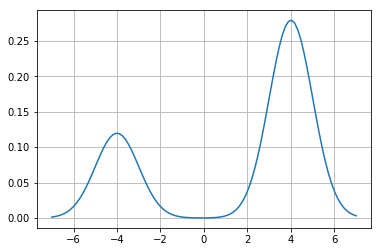

In [167]:
from scipy.stats import norm
from scipy.misc import logsumexp
def plot_gaussian_mixture(weights, locations, scales):
    def log_p(x):
        return logsumexp([np.log(w) + norm.logpdf(x, l, s)
                          for w, l, s in zip(weights, locations, scales)])
    axes = plt.figure().add_subplot(111)
    xs = np.linspace(locations[0] - 3*scales[0],
                     locations[-1] + 3*scales[-1],
                     100)
    axes.plot(xs, [np.exp(log_p(_)) for _ in xs])
    axes.grid()
    return log_p
log_p = plot_gaussian_mixture(
    weights=[0.3, 0.7], locations=[-4, 4], scales=[1, 1])

In [168]:
def test_mcmc(n_chains=1):
    inits = [np.random.random() for _ in range(n_chains)]
    mcmc = Metropolis(log_p, inits)
    n_samples = 1000
    for _ in range(n_samples):
        mcmc.sample()
    n_burnins = 300
    # shape: `[n_chains, n_samples-n_burnins]`
    samples = np.transpose(mcmc.samples)[:,n_burnins:]
    for chain in samples:
        plt.hist(chain, bins=50, normed=True)
    # As comparison
    xs = np.linspace(-7, 7, 100)
    plt.plot(xs, [np.exp(log_p(_)) for _ in xs])
    plt.show()

One chain is not essential:

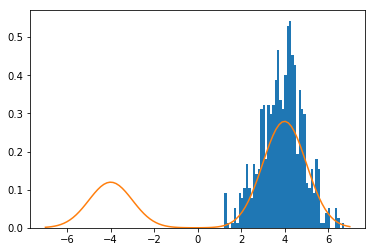

In [161]:
test_mcmc()

More chains, however, still won't work:

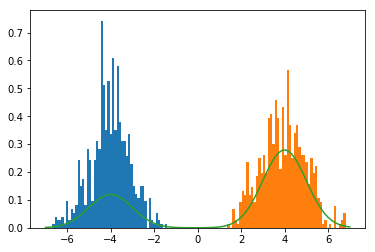

In [163]:
test_mcmc(n_chains=2)

* Even for this simple **one-dimensional** distribution, MCMC can be non-convergent!

The reason:
  * The samples in the two distinct region cannot communicate with each other.

## The modern: VI

### What is VI

Define K-L divergence:
\begin{equation}
  \textrm{KL}( q \| p )
  = \mathbb{E}_{\theta \sim q} \left[ \ln q(\theta) - \ln p(\theta) \right]
\end{equation}

If $q \to q(\theta; z)$, then define the loss-function as
\begin{align}
  \mathcal{L}(z)
  & = \mathbb{E}_{\theta \sim q} \left[
    \ln q(\theta; z) - \ln p(\theta \mid D, H)
  \right] \\
  & = \mathbb{E}_{\theta \sim q} \left[
    \ln q(\theta; z) - \ln p(D \mid \theta, H) - \ln p(\theta, H)
  \right] + \ln p(D, H)
\end{align}

In [172]:
from tqdm import tqdm
from nn4post import Inferencer
from nn4post.utils import get_param_shape, get_param_space_dim
from nn4post.utils.tf_trainer import SimpleTrainer
from uba.utils.math import softplus, softmax

def vi(n_c, n_dims, log_p, n_iters):
  inferencer = Inferencer(n_c, n_dims, log_p)
  with tf.name_scope('variables'):
    a = tf.Variable(
        np.zeros([n_c]),
        dtype='float32',
        name='a')
    mu = tf.Variable(
        np.random.normal(size=[n_c, n_dims]),
        dtype='float32',
        name='mu')
    zeta = tf.Variable(
        np.zeros([n_c, n_dims]),
        dtype='float32',
        name='zeta')
  var = {'a': a, 'mu': mu, 'zeta': zeta}
  loss, gradients = inferencer.make_loss_and_gradients(**var)
  optimizer = tf.train.AdamOptimizer(0.01)
  train_op = optimizer.apply_gradients(gradients)
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in tqdm(range(n_iters)):
      sess.run(train_op)
    return sess.run([a, mu, zeta])
  
def get_samples(a, mu, zeta, n_samples):
    samples = []
    weights = softmax(a)
    for _ in range(n_samples):
        i = np.random.choice(a.shape[0], p=weights)
        sample = (mu[i,:] + softplus(zeta[i,:]) 
                  * np.random.normal(size=mu.shape[1]))
        samples.append(sample)
    return np.array(samples)

In [174]:
def test_vi(n_c=3, n_iters=500, n_samples=1000):
    tf.reset_default_graph()
    # Get the `log_p` argument for `vi()`
    normal_dists = [tfd.Normal(-4, 1), tfd.Normal(4, 1)]
    cat_dist = tfd.Categorical(probs=[0.3, 0.7])
    dist = tfd.Mixture(cat_dist, normal_dists)
    # Run VI and then sample
    n_dims = 1
    a, mu, zeta = vi(n_c, n_dims, dist.log_prob, n_iters)
    samples = get_samples(a, mu, zeta, n_samples)
    plt.hist(samples[:,0], bins=50, normed=True)
    # As comparison
    xs = np.linspace(-7, 7, 100)
    plt.plot(xs, [np.exp(log_p(_)) for _ in xs])
    plt.show()

100%|██████████| 500/500 [05:10<00:00,  1.61it/s]


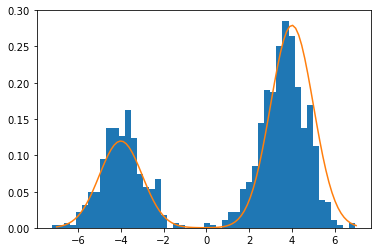

In [175]:
test_vi()

Splendid, as it should be.

### Pros and cons

#### Pros: efficiency

* Escapes the curse of dimensionality.
* Fast convergence. You can gain the result in minutes.
* The accuracy can be easily measured.

##### Escapes the curse of dimensionality

In [226]:
def test_vi_high_dim(n_dims, n_c=3, n_iters=500,
                     n_samples=1000, show_axis=0):
    """Test on multivariate normal distribution with a
    diagonal covariance."""
    tf.reset_default_graph()
    # Get the `log_p` argument for `vi()`
    dist = tfd.MultivariateNormalDiag(
        tf.zeros([n_dims]), tf.ones([n_dims]))
    # Run VI and then sample
    a, mu, zeta = vi(n_c, n_dims, dist.log_prob, n_iters)
    samples = get_samples(a, mu, zeta, n_samples)
    plt.hist(samples[:,show_axis], bins=50, normed=True)
    # As comparison
    xs = np.linspace(-3, 3, 100)
    plt.plot(xs, [sp.stats.norm.pdf(_) for _ in xs])
    plt.show()

100%|██████████| 500/500 [04:57<00:00,  1.68it/s]


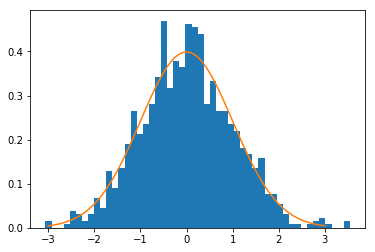

In [227]:
test_vi_high_dim(n_dims=10000)

(To be compared with the following SVGD.)

#### cons: accuracy

* Needs expert experience.
* Accuracy is not promised (but can be measured).
* Can only be applied to continuous parameter space.

##### Accuracy is not promised

In [220]:
def test_vi_complex(complex_log_p_tf, complex_log_p_np,
                    n_c=5, n_iters=500, n_samples=1000):
    """One-dimensional."""
    # Run VI and then sample
    n_dims = 1
    a, mu, zeta = vi(n_c, n_dims, complex_log_p_tf, n_iters)
    samples = get_samples(a, mu, zeta, n_samples)
    plt.hist(samples[:,0], bins=50, normed=True)
    # As comparison
    xs = np.linspace(np.min(samples), np.max(samples), 100)
    plt.plot(xs, [np.exp(complex_log_p_np(_)) for _ in xs])
    plt.show()

100%|██████████| 500/500 [10:12<00:00,  1.22s/it]


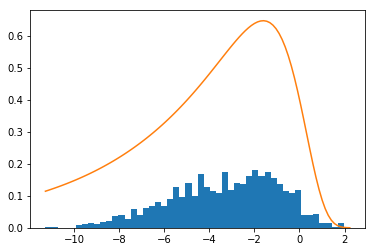

In [221]:
tf.reset_default_graph()
def complex_log_p_tf(x):
  return tfd.Gamma(1.2, 1.0).log_prob(tf.exp(x))
def complex_log_p_np(x):
  return sp.stats.gamma.logpdf(np.exp(x), a=1.2)
test_vi_complex(complex_log_p_tf, complex_log_p_np)

## SVGD and Neural Network Sampler

### What is SVGD

Gradient boosting to the K-L divergence:

Let $T(x) := x + \epsilon \phi(x)$ for some $\phi(x)$,
\begin{equation}
  \textrm{KL}( q_{[T]} \| p )
  = \textrm{KL}( q \| p )
  - \epsilon \langle \nabla \textrm{KL}, \phi \rangle_{\mathcal{H}^N}
  + \mathcal{O}(\epsilon^2)
\end{equation}
where
\begin{equation}
  \nabla \textrm{KL}(y)
  := \mathbb{E}_{x \sim q} \left[
    \left( \nabla \ln p(x) - \nabla \ln k(x, y) \right) k(x, y)
  \right].
\end{equation}
Thus the $\nabla \textrm{KL}(y)$ is the fastest "direction" that decreases the $\textrm{KL}(q \| p)$.

In [69]:
def get_median(v):
  """Auxillary function."""
  v = tf.reshape(v, [-1])
  m = v.shape[0].value//2
  return tf.nn.top_k(v, m).values[m-1]

class SVGD(object):

  @staticmethod
  def initialize_samples(n_samples, n_dims):
    samples_shape = [n_samples, n_dims]
    initializer = tf.initializers.random_uniform(minval=-1, maxval=1)
    samples = tf.get_variable(
        'samples', shape=samples_shape,
        dtype='float32', initializer=initializer)
    return samples
  
  @staticmethod
  def rbf_kernel(xs, ys, name=None):
    """Returns :math:`k(x_i, y_j)` and :math:`\nabla k(x_i, y_j)`,
    for :math:`\forall i, j = 1, \ldots m` for some :math:`m`, and
    :math:`x_i, y_j \in \mathbb{R}^n`, where the :math:`k(\cdot, \cdot)`
    is the RBF kernel.
  
    Args:
      xs: Tensor of the shape `[m, n]` for some `m` and `n`.
      ys: Tensor of the same shape as `xs`.
    Returns:
      Two tensors. The first is of shape `[m, m]`, the second is of
      `[n, m, m]`.
    """
    with tf.name_scope(name, 'RBFKernel', [xs, ys]):
      with tf.name_scope('Pairwise'):
        m, n = xs.get_shape().as_list()
        # :math:`x_i^{\alpha} - y_j^{\alpha}`, shape `[m, m, n]`
        deltas = tf.subtract(
            tf.expand_dims(xs, axis=1),
            tf.expand_dims(ys, axis=0),
            name='Deltas')
        # :math: \sum_{\alpha} (x_i^{\alpha} - y_j^{\alpha})^2,
        # shape `[m, m]`
        square_distances = tf.reduce_sum(
            tf.square(deltas), axis=-1,
            name='SquareDistances')
        h = tf.truediv(
            get_median(square_distances),
            tf.log(float(m)),
            name='h')
        # :math:`k(x_i, y_j)`, shape `[m, m]`
        kxy = tf.exp(-1 / h * square_distances, name='Pairwise')
      with tf.name_scope('PairwiseGradients'):
        # :math:`\nabla_{\alpha} k(x_i, y_j)`, shape `[m, m, n]
        grad_kxy_by_x = tf.multiply(
            -1 / h * deltas,
            tf.expand_dims(kxy, axis=-1))
      return kxy, grad_kxy_by_x

  @staticmethod
  def linear_kernel(xs, ys, name=None):
    with tf.name_scope(name, 'LinearKernel', [xs, ys]):
      with tf.name_scope('Pairwise'):
        m, n = xs.get_shape().as_list()
        # :math:`x_i^{\alpha} x_j^{\alpha}`, shape `[m, m, n]`
        pairwise = tf.multiply(
            tf.expand_dims(xs, axis=1),
            tf.expand_dims(ys, axis=0))
      with tf.name_scope('Kernel'):
        # :math:`\sum_{\alpha} x_i^{\alpha} x_j^{\alpha}`,
        # shape `[m, m]`
        kxy = tf.reduce_sum(pairwise, axis=-1)
      with tf.name_scope('Gradient'):
        # :math:`x_j^{\alpha}`， # shape `[m, m, n]`
        grad_kxy_by_x = tf.stack([ys]*m, axis=0)
      return kxy, grad_kxy_by_x

  @staticmethod
  def get_phi_stars(kernel, samples, log_p, name='PhiStars'):
    """:math:`phi_{\star}(x_j) \forall x_j \in \mathbb{R}^n`
    with :math:`j = 1, \ldots m`.
  
    Args:
      kernel: Callable that maps pair of tensors of the shape
        `[m, n]` to pair of tensors of the shape `[m, m]` and
        `[m, m, n]`, as the :math:`k(x_i, x_j)` and
        :math:`\nabla_{\alpha} k(x_i, x_j)`.
      samples: Tensor of the shape `[m, n]`.
      log_p: Callable that maps tensor of the shape `[n]` to scalar.
    
    Returns:
      Tensor of the shape `[m, n]`.
    """
    m, n = samples.get_shape().as_list()
    # :math:`\ln p (x_i) \forall x_i`, shape `[m]`
    log_ps = tf.map_fn(log_p, samples, name='LogProbabilities')
    # :math:`\nabla \ln p (x_i) \forall x_i`, shape `[m, n]`
    grad_log_ps = tf.gradients(log_ps, [samples])[0]
    # :math:`k(x_i, x_j)` and `\nabla k(x_i, x_j)`,
    # shape `[m, m]` and `[m, m, n]`, respectively
    ks, grad_ks = kernel(samples, samples)
    with tf.name_scope(name):
      # Broadcasting for gaining the `phi_stars`
      ks = tf.expand_dims(ks, axis=-1)  # [m, m, 1]
      grad_log_ps = tf.expand_dims(grad_log_ps, axis=1)  # [m, 1, n]
      # shape 
      integrand = ks * grad_log_ps + grad_ks  # [m, m, n]
      # :math:`phi_{\star}(x_j) \forall x_j`, shape `[m, n]`
      phi_stars = tf.reduce_mean(integrand, axis=0)
      return phi_stars
  
  def main(self, n_samples, n_dims, log_p, n_iters,
           kernel=None, optimizer=None, skip_step=100,
           show_axis=0):
    xs = self.initialize_samples(n_samples, n_dims)
    if kernel is None:
      kernel = self.rbf_kernel
    phi_stars = self.get_phi_stars(kernel, xs, log_p)
    mean_square_grad = tf.reduce_mean(tf.square(phi_stars))

    if optimizer is None:
      optimizer = tf.train.AdamOptimizer(0.01, beta1=0, beta2=0.9)
    train_op = optimizer.apply_gradients([(-phi_stars, xs)])

    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())

      for step in range(n_iters):
        _, mean_square_grad_val = sess.run([train_op, mean_square_grad])
        if step % skip_step == 0:
          print('After step {}'.format(step))
          print('Mean-square-gradient {}'.format(mean_square_grad_val))
          xs_val = sess.run(xs)
          plt.hist(xs_val[:,show_axis], bins=50, normed=True)
          plt.show()

      print('Finally')
      xs_val = sess.run(xs)
      plt.hist(xs_val[:,show_axis], bins=50, normed=True)
      plt.show()

Test on Gaussian mixture distribution:

After step 0
Mean-square-gradient 0.06002242490649223


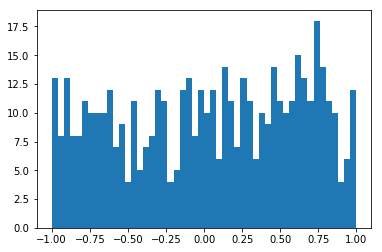

After step 100
Mean-square-gradient 0.03231942653656006


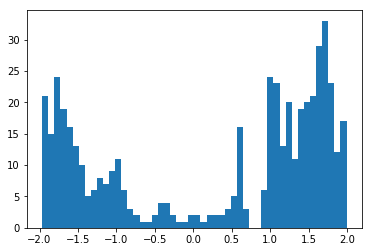

After step 200
Mean-square-gradient 0.00038037949707359076


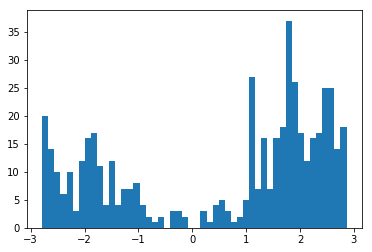

After step 300
Mean-square-gradient 4.440446900844108e-06


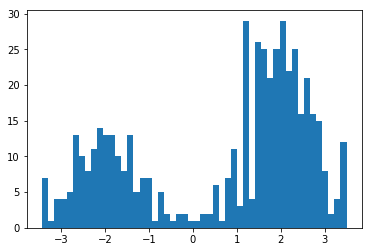

After step 400
Mean-square-gradient 5.433600563264918e-06


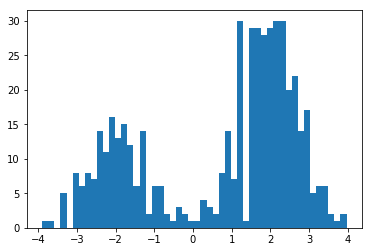

Finally


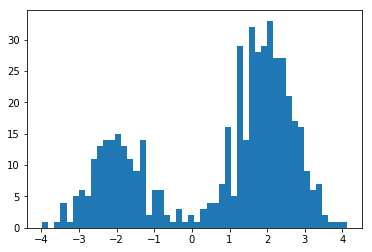

CPU times: user 7min 43s, sys: 47.6 s, total: 8min 30s
Wall time: 2min 27s


In [76]:
%%time

tf.reset_default_graph()

n_samples = 500
n_dims = 1
normals = [
    tfd.Independent(
        tfd.Normal(-2*tf.ones([n_dims]), tf.ones([n_dims]))),
    tfd.Independent(
        tfd.Normal(2*tf.ones([n_dims]), tf.ones([n_dims]))),
]
dist = tfd.Mixture(tfd.Categorical([0.3, 0.7]),
                   normals)
SVGD().main(n_samples, n_dims, dist.log_prob, n_iters=500)

### Pros and cons

#### Pros:
* Efficiency & accuracy (extremely light and fast)
* Can be extended to neural network sampler.

##### Towards the neural network sampler

In [82]:
Image(url=('https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/'
           '42a712dbfe07262ba2b479e800008f08ad1c1388/2-Figure1-1.png'))

And possibility a data-compressor.

#### Cons: 
* Curse of dimensionality.
* Unstable for different kernels.
* Accuracy cannot be easily measured.
* Can only be applied to continuous parameter space.

##### Curse of dimensionality

As the `n_dims` increases, the trained distribution comes to be nearly MAP (thus goes back to the traditional machine learning):

After step 0
Mean-square-gradient 1.2573191270348616e-06


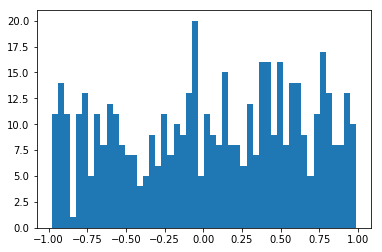

After step 100
Mean-square-gradient 1.4931912373228329e-09


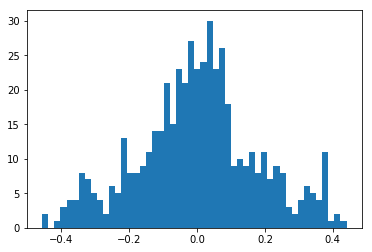

After step 200
Mean-square-gradient 2.2550061817838696e-09


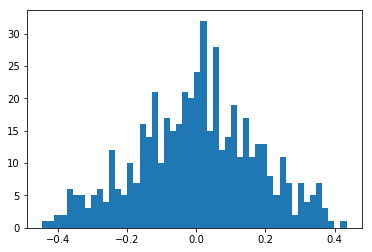

After step 300
Mean-square-gradient 2.3150641403901773e-09


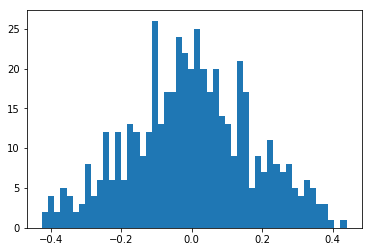

After step 400
Mean-square-gradient 2.358443662586751e-09


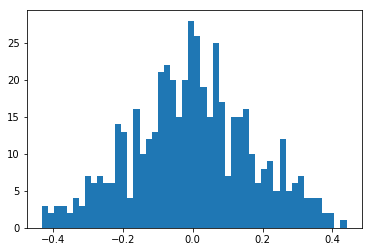

Finally


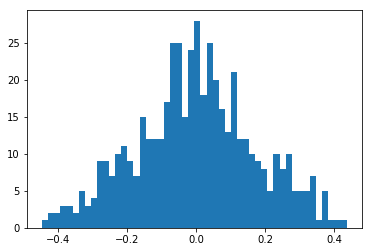

CPU times: user 4min 44s, sys: 24.6 s, total: 5min 9s
Wall time: 1min 14s


In [78]:
%%time

tf.reset_default_graph()

n_samples = 500
n_dims = 100
dist = tfd.Independent(
  tfd.Normal(tf.zeros([n_dims]), tf.ones([n_dims])))
SVGD().main(n_samples, n_dims, dist.log_prob, n_iters=500, show_axis=0)

Notice that the range of domain is about $(-0.4, 0.4)$, rather than $(-1, 1)$. Thus it comes to be nearly MAP. Thus suffers the curse of dimensionality. (Compare with that in VI in the previous.)

Why the curse?

In high-dimensional, the distances between samples are enlarged, so that a sample cannot perceive the other samples. So it cannot properly estimate the global performance. Instead, to gain the performance (its own performance), it moves to the MAP point.

To solve this problem, abstraction is called for, that is, projecting the samples to a much smaller, but much compacter, manifold. In this manifold, the samples are related (like being related by latent variables). Global performance can thus be estimated and weighted between different samples, even superficially they cannot perceive each other, providing a meaningful variation of the latent parameters on the manifold.

##### Unstable for different kernels.

Some kernel even makes all things wrong. E.g. linear kernel:

After step 0
Mean-square-gradient 0.14785335958003998


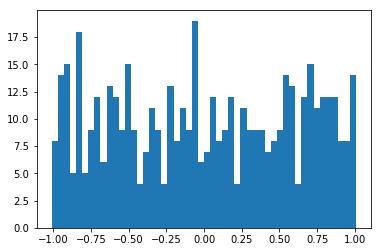

After step 100
Mean-square-gradient 6.089311387481693e-16


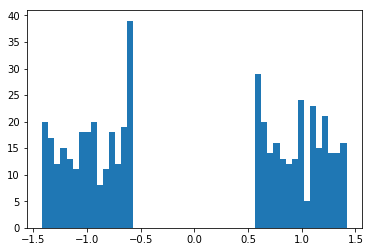

After step 200
Mean-square-gradient 6.397622928489e-05


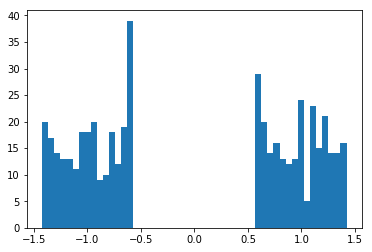

After step 300
Mean-square-gradient 9.311195753980428e-05


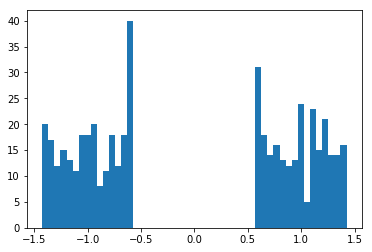

After step 400
Mean-square-gradient 9.296229836763814e-05


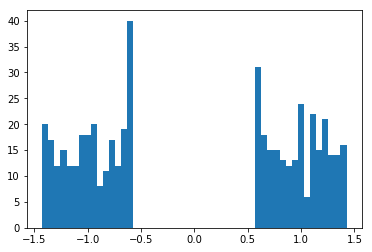

Finally


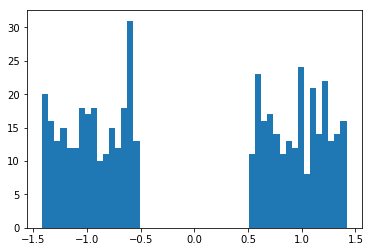

CPU times: user 4min 32s, sys: 23.5 s, total: 4min 56s
Wall time: 1min 3s


In [79]:
%%time

tf.reset_default_graph()

n_samples = 500
n_dims = 1
dist = tfd.Independent(
  tfd.Normal(tf.zeros([n_dims]), tf.ones([n_dims])))
SVGD().test(n_samples, n_dims, dist, n_iters=500,
            kernel=SVGD().linear_kernel)